In [1]:
import ROOT
import os
from pyroot_cms_scripts import CMS_style, CMS_text

Welcome to JupyROOT 6.18/00


In [2]:
set_variable_defaults = """
hist_filename = "signal_loose_W_mu.root"
variable = "lept_pt1"
title_x = "lept_{1} p_{T}"
units = "GeV"
custom_title_y = ""
show_bw = True
scale_y_axis = 1.4
axis_max_digits = 4
leg_pos = [0.55, 0.65, 0.95, 0.9]
leg_columns = 2

draw_with_ratio = True

lower_graph_draw_opt = "p"
lower_graph_max_y = 2.5
lower_graph_min_y = 0.0
lower_graph_ndivisions_y = 404
lower_graph_title_y = "#frac{Data}{MC}"

skip_Top = False
skip_WJets = False
skip_QCD = False
skip_DYJets = False
skip_VBS_QCD = False
skip_VBS_EWK = False

skip_dataM = False
skip_dataE = False

make_cms_text = True

plots_dir = "plots"
"""

In [140]:
plot_mc_data = """
print("-----------------------")
print("")
print(hist_filename)
print("")
print("-----------------------")


if units != "":
    title_x = f"{title_x} ({units})"

if custom_title_y == "":
    title_y = "Events"
    
# Force CMS_style
# ==============
ROOT.TGaxis().SetMaxDigits(axis_max_digits)
CMS_style.SetLabelSize(0.042, "XYZ")
CMS_style.cd()
ROOT.gROOT.ForceStyle()

hist_file = ROOT.TFile.Open(hist_filename)

# make stack of mc samples
# overlay data with points
# ========================
legend = ROOT.TLegend(leg_pos[0], leg_pos[1], leg_pos[2], leg_pos[3])
legend.SetFillStyle(0)
legend.SetBorderSize(0)
legend.SetTextFont(42)
legend.SetTextSize(0.03)
legend.SetNColumns(leg_columns)

h_dataM = hist_file.Get(f"dataM_{variable}")
h_dataE = hist_file.Get(f"dataE_{variable}")

if skip_dataM:
    h_dataM.Reset()

if skip_dataE:
    h_dataE.Reset()

h_data = h_dataM + h_dataE

if h_data.GetEntries() != 0.0:
    legend.AddEntry(h_data, "Data", "pe")

bw = h_data.GetBinWidth(1)

if show_bw:
    title_y = f"{title_y} / {bw} {units}"

h_mc = ROOT.THStack("h_mc", f";{title_x};{title_y}")

h_Top = hist_file.Get(f"Top_{variable}")
h_Top.SetFillColor(ROOT.TColor.GetColor(155, 152, 204))
h_Top.SetLineColor(ROOT.TColor.GetColor(155, 152, 204))
h_Top.SetFillStyle(1001)

h_WJets = hist_file.Get(f"WJets_{variable}")
h_WJets.SetFillColor(ROOT.TColor.GetColor(222, 90, 106))
h_WJets.SetLineColor(ROOT.TColor.GetColor(222, 90, 106))
h_WJets.SetFillStyle(1001)

h_QCD = hist_file.Get(f"QCD_{variable}")
h_QCD.SetFillColor(ROOT.kCyan + 2)
h_QCD.SetLineColor(ROOT.kCyan + 2)
h_QCD.SetFillStyle(1001)

h_DYJets = hist_file.Get(f"DYJets_{variable}")
h_DYJets.SetFillColor(ROOT.TColor.GetColor(248, 206, 104))
h_DYJets.SetLineColor(ROOT.TColor.GetColor(248, 206, 104))
h_DYJets.SetFillStyle(1001)

h_VBS_QCD = hist_file.Get(f"VBS_QCD_{variable}")
h_VBS_QCD.SetFillColor(ROOT.TColor.GetColor(250, 202, 255))
h_VBS_QCD.SetLineColor(ROOT.TColor.GetColor(250, 202, 255))
h_VBS_QCD.SetFillStyle(1001)

h_VBS_EWK = hist_file.Get(f"VBS_EWK_{variable}")
h_VBS_EWK.SetFillColor(ROOT.kMagenta)
h_VBS_EWK.SetLineColor(ROOT.kMagenta)
h_VBS_EWK.SetFillStyle(1001)

if h_Top.GetEntries() == 0.0: skip_Top = True
if not skip_Top:
    legend.AddEntry(h_Top, f"Top ({h_Top.Integral():.2f})", "f")
    h_mc.Add(h_Top)

if  h_WJets.GetEntries() == 0.0: skip_WJets = True
if not skip_WJets:
    legend.AddEntry(h_WJets, f"W + Jets ({h_WJets.Integral():.2f})", "f")
    h_mc.Add(h_WJets)

if h_QCD.GetEntries() == 0.0: skip_QCD = True
if not skip_QCD:
    legend.AddEntry(h_QCD, f"QCD ({h_QCD.Integral():.2f})", "f")
    h_mc.Add(h_QCD)

if h_DYJets.GetEntries() == 0.0: skip_DYJets = True
if not skip_DYJets:
    legend.AddEntry(h_DYJets, f"DY Jets ({h_DYJets.Integral():.2f})", "f")
    h_mc.Add(h_DYJets)

if h_VBS_QCD.GetEntries() == 0.0: skip_VBS_QCD = True
if not skip_VBS_QCD:
    legend.AddEntry(h_VBS_QCD, f"VBS QCD ({h_VBS_QCD.Integral():.1f})", "f")
    h_mc.Add(h_VBS_QCD)

if h_VBS_EWK.GetEntries() == 0.0: skip_VBS_EWK = True
if not skip_VBS_EWK:
    legend.AddEntry(h_VBS_EWK, f"VBS EWK ({h_VBS_EWK.Integral():.1f})", "f")
    h_mc.Add(h_VBS_EWK)

maxY = max(h_data.GetMaximum(), h_mc.GetMaximum())
minY = min(h_data.GetMinimum(), h_mc.GetMinimum())

h_mc.SetMaximum(maxY * scale_y_axis)

if minY < 0:
    h_mc.SetMinimum(minY * scale_y_axis)

h_mc_sum = h_mc.GetStack().Last().Clone("mc_sum")

h_mc_sum_copy_for_errors = h_mc_sum.Clone("mc_sum_errors")
h_mc_sum_copy_for_errors.SetFillStyle(3003)
h_mc_sum_copy_for_errors.SetMarkerStyle(0)
h_mc_sum_copy_for_errors.SetFillColor(1)

h_data_total = h_data.Clone("data_total")
h_data_total.SetTitle(h_mc.GetTitle())

canvas = ROOT.TCanvas()

if not draw_with_ratio:
        
    h_mc.Draw("hist")
    h_data.Draw("x0 e1 same")
    h_mc_sum_copy_for_errors.Draw("e2 same")

    legend.Draw()

    if make_cms_text:
        CMS_text(
            canvas,
            cms_text_location="inside left",
            cms_pos_y_scale=0.9,
            draw_extra_text=True,
            extra_text_location="inside left right",
            extra_text="#scale[1.0]{Preliminary}",
            extra_text_pos_y_scale=0.9,
            draw_lumi_text=True,
            lumi_text="#scale[1.0]{35.9 fb^{-1} (13 TeV)}"
        )

if draw_with_ratio:

    ratio = ROOT.TRatioPlot(h_data_total, h_mc_sum)

    ratio.SetGraphDrawOpt(lower_graph_draw_opt)

    ratio.SetSeparationMargin(0)
    ratio.SetLeftMargin(canvas.GetLeftMargin())
    ratio.SetRightMargin(canvas.GetRightMargin())
    ratio.SetUpTopMargin(0.075)
    ratio.SetLowBottomMargin(0.40)

    ratio.Draw("grid hideup")

    ratio.GetLowYaxis().SetNdivisions(lower_graph_ndivisions_y)
    ratio.GetLowerRefYaxis().CenterTitle()
    ratio.GetLowerRefYaxis().SetTitleSize(0.04)
    ratio.GetLowerRefYaxis().SetTitleOffset(1.8)
    ratio.GetLowerRefYaxis().SetLabelSize(0.035)
    ratio.GetLowerRefYaxis().SetTitle(lower_graph_title_y)
    ratio.GetLowerRefGraph().SetMinimum(lower_graph_min_y)
    ratio.GetLowerRefGraph().SetMaximum(lower_graph_max_y)
    ratio.GetLowerRefGraph().SetMarkerStyle(6)

    upper_pad = ratio.GetUpperPad()
    upper_pad.cd()

    h_mc_sum.Reset()
    h_data_total.Reset()
    h_mc.Draw("ah hist")
    h_mc_sum_copy_for_errors.Draw("e2 same")
    h_data.Draw("x0 e1 same")

    legend.Draw()
    
    if make_cms_text:
        CMS_text(
            upper_pad,
            cms_text_scale=1.2,
            cms_text_location="inside left",
            cms_pos_y_scale=0.95,
            draw_extra_text=True,
            extra_text_location="inside left right",
            extra_text="#scale[1.2]{Preliminary}",
            extra_text_pos_x_scale=1.0,
            extra_text_pos_y_scale=0.94,
            draw_lumi_text=True,
            lumi_text="#scale[1.1]{35.9 fb^{-1} (13 TeV)}"
        )
    
#os.makedirs(f"{plots_dir}", exist_ok=True)
canvas.Draw()
#canvas.SaveAs(f"{plots_dir}/{variable}_{hist_filename.split('.')[0]}.pdf")
"""

-----------------------

signal_loose_W_mu.root

-----------------------


Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 5 points have been skipped


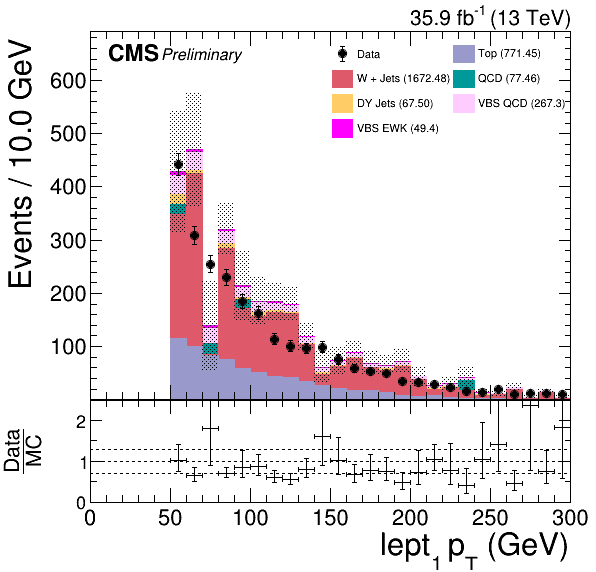

In [141]:
exec(set_variable_defaults)
exec(plot_mc_data)

-----------------------

signal_loose_Z_mu.root

-----------------------


Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 5 points have been skipped


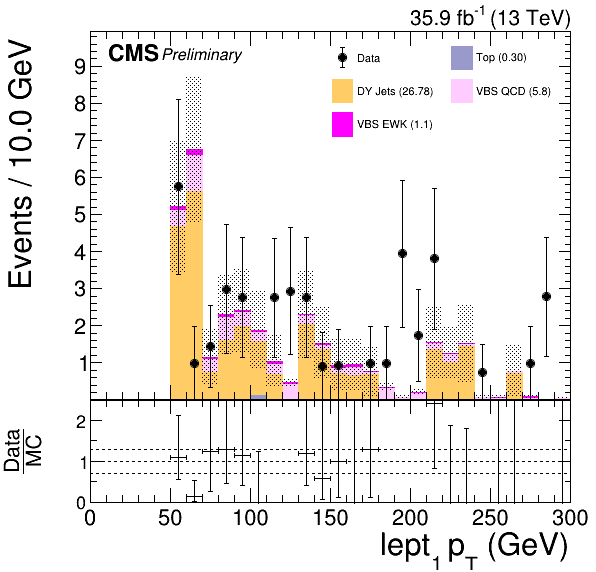

In [142]:
exec(set_variable_defaults)
hist_filename = "signal_loose_Z_mu.root"
skip_QCD = True
exec(plot_mc_data)

-----------------------

signal_tight_W_mu.root

-----------------------


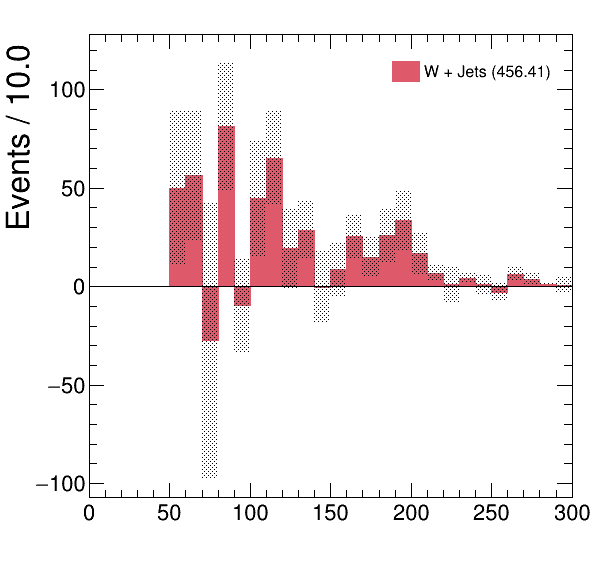

In [145]:
exec(set_variable_defaults)
hist_filename = "signal_tight_W_mu.root"
variable = "lept_pt1"
units = ""
title_x = ""

leg_pos = [0.65, 0.85, 0.9, 0.9]
leg_columns = 1

skip_dataE = True
skip_dataM = True
skip_QCD = True
skip_WJets = False
skip_VBS_QCD = True
skip_VBS_EWK = True
skip_Top = True
skip_DYJets = True

draw_with_ratio = False

make_cms_text = False

scale_y_axis = 1.5

#plot_mc_data.replace("inside left", "outside left").replace("minY * scale_y_axis", "minY * 4.0")
exec(plot_mc_data.replace("inside left", "outside left").replace("minY * scale_y_axis", "minY * 3.9"))

-----------------------

signal_tight_W_mu.root

-----------------------


Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 5 points have been skipped


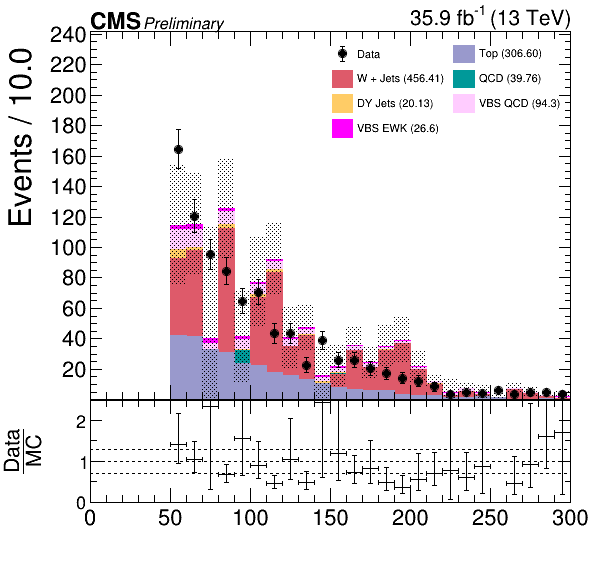

In [144]:
exec(set_variable_defaults)
hist_filename = "signal_tight_W_mu.root"
variable = "lept_pt1"
units = ""
title_x = ""

exec(plot_mc_data.replace("inside left", "outside left"))

-----------------------

signal_tight_W_mu.root

-----------------------


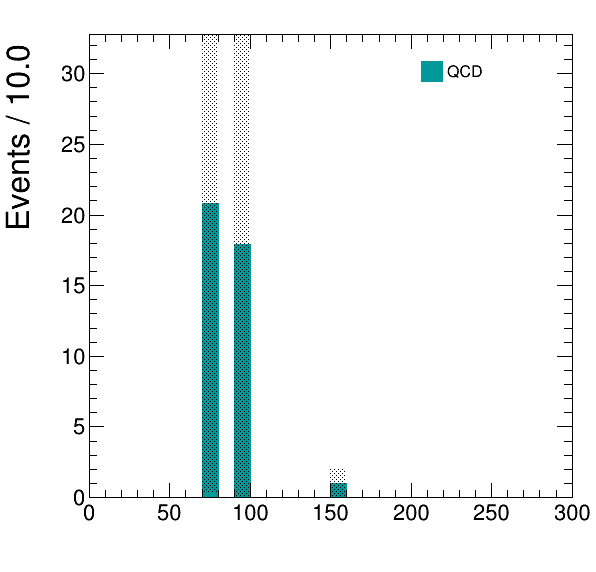

In [94]:
exec(set_variable_defaults)
hist_filename = "signal_tight_W_mu.root"
variable = "lept_pt1"
units = ""
title_x = ""

leg_pos = [0.7, 0.85, 0.9, 0.9]
leg_columns = 1

skip_dataE = True
skip_dataM = True
skip_QCD = False
skip_WJets = True
skip_VBS_QCD = True
skip_VBS_EWK = True
skip_Top = True
skip_DYJets = True

draw_with_ratio = False

make_cms_text = False

scale_y_axis = 1.5

#plot_mc_data.replace("inside left", "outside left").replace("minY * scale_y_axis", "minY * 4.0")
exec(plot_mc_data.replace("inside left", "outside left").replace("minY * scale_y_axis", "minY * 3.9"))